# Minneapolis Scooter Analysis

One of the more fun datasets in the [Minneapolis Open Data](http://opendata.minneapolismn.gov/) project is the scooter data.  It doesn't have a whole lot to work with, but is still certainly interesting to see trends and patterns in scooter rides.  Let's have a look!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
trips = {}
for sheet in range(7):
    trips[sheet] = pd.read_excel('Scooter_Trips.xlsx',sheet_name=sheet)

In [5]:
scooter = pd.concat([trips[0],trips[1],trips[2],trips[3],trips[4],trips[5],trips[6]])

In [6]:
scooter.head()

,FID,TripID,TripDuration,TripDistance,StartTime,EndTime,StartCenterlineID,StartCenterlineType,EndCenterlineID,EndCenterlineType,ObjectId
0,1.0,1047,2866,9521,2019-05-13 20:29:59,2019-05-13 21:00:00,NaN,trail,NaN,trail,NaN
1,2.0,1053,1387,5753,2019-05-13 20:29:59,2019-05-13 21:00:00,17242,street,11720,street,NaN
2,3.0,1060,962,1630,2019-05-13 20:29:59,2019-05-13 21:00:00,19502,street,17104,street,NaN
3,4.0,1048,423,2149,2019-05-13 20:29:59,2019-05-13 20:29:59,18092,street,15446,street,NaN
4,5.0,1042,3813,6943,2019-05-13 20:29:59,2019-05-13 21:30:00,18617,street,NaN,trail,NaN


In [7]:
scooter.dtypes

FID                    float64
TripID                   int64
TripDuration             int64
TripDistance             int64
StartTime               object
EndTime                 object
StartCenterlineID       object
StartCenterlineType     object
EndCenterlineID         object
EndCenterlineType       object
ObjectId               float64
dtype: object

In [13]:
scooter['StartTime'] = pd.to_datetime(scooter['StartTime'],format='%Y-%m-%d %H:%M:%S',errors='coerce')
scooter['EndTime'] = pd.to_datetime(scooter['EndTime'],format='%Y-%m-%d %H:%M:%S',errors='coerce')

In [14]:
scooter.dtypes

FID                           float64
TripID                          int64
TripDuration                    int64
TripDistance                    int64
StartTime              datetime64[ns]
EndTime                datetime64[ns]
StartCenterlineID              object
StartCenterlineType            object
EndCenterlineID                object
EndCenterlineType              object
ObjectId                      float64
dtype: object

In [15]:
scooter['month'] = scooter['StartTime'].dt.month
scooter['hour'] = scooter['StartTime'].dt.hour

Text(0.5, 1.0, 'Number of Rides per Month')

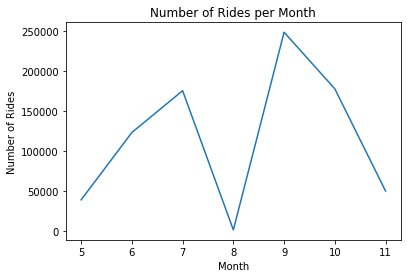

In [43]:
plt.plot(scooter.groupby('month')['TripID'].count())
plt.xlabel('Month')
plt.ylabel('Number of Rides')
plt.title('Number of Rides per Month')

Text(0.5, 1.0, 'Number of Rides by Time of Day')

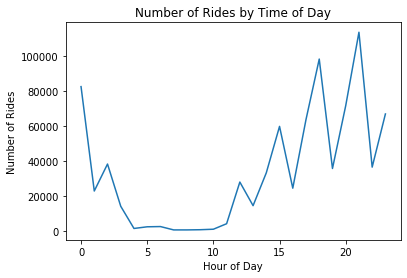

In [44]:
plt.plot(scooter.groupby('hour')['TripID'].count())
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Time of Day')

In [23]:
#convert trip duration from seconds to minutes
scooter['TripDuration'] = scooter['TripDuration']/60
#convert trip distance from meters (I think) to miles
scooter['TripDistance'] = scooter['TripDistance']/1000*.62137

Let's check the stats on trip duration.

In [25]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)
scooter.describe()['TripDuration']

count   1040551.0
mean         13.8
std          18.6
min         -13.0
25%           4.5
50%           7.7
75%          15.3
max         419.8
Name: TripDuration, dtype: float64

Interesting stuff here.  Average ride of about 14 minutes with a maximum of 7 hours.  Clearly someone forgot to "end ride"!

Okay what about trip distance?

In [26]:
scooter.describe()['TripDistance']

count   1040551.0
mean          1.1
std           1.2
min           0.0
25%           0.4
50%           0.7
75%           1.4
max          24.0
Name: TripDistance, dtype: float64

Or maybe the person did ride for 7 hours and they made it 24 miles in that time, who knows.  The average ride is 1.1 miles.  That seems about right.

There is a field that tells us if the ride is on a street or trail.  Let's check out the distribution of that data.

In [41]:
scooter.groupby('StartCenterlineType')['TripID'].count()

StartCenterlineType
street    917273
trail     123278
Name: TripID, dtype: int64

I'm curious to see average speed on these rides.  Let's calculate miles per hour.

In [47]:
scooter['mph'] = scooter['TripDistance']/(scooter['TripDuration']/60)

In [48]:
scooter.describe()['mph']

count   1040551.0
mean          6.0
std           4.0
min        -582.9
25%           3.7
50%           6.0
75%           8.1
max         688.2
Name: mph, dtype: float64

I'm extremely impressed with the people who managed to go -582 and 688 miles per hour.  

Mean of 6 mph and standard deviation of 4 mph seems about right.  These things have a max speed of 15-20 mph.

Another piece of this data is the breakdown of scooter availability by scooter company and neighborhood.  Unfortunately I don't see a way to tie an individual ride to either of these data points, but we can see aggregated totals of available scooters by company and neighborhood of Minneapolis.

In [32]:
supply = pd.read_csv('Scooter_Availability.csv')

In [33]:
supply.head()

,FID,PollTime,CompanyName,NumberAvailable,ClosestCenterlineID,ClosestCenterlineType,Neighborhood
0,1,2019/05/17 08:00:00,Lime,1,18282.0,street,Cleveland
1,2,2019/05/17 08:00:00,Lime,2,20748.0,street,Sheridan
2,3,2019/05/17 08:00:00,Lime,1,21914.0,street,Midtown Phillips
3,4,2019/05/17 08:00:00,Lime,1,10464.0,street,Lind - Bohanon
4,5,2019/05/17 08:00:00,Lime,1,11499.0,street,Como


In [42]:
supply.groupby('CompanyName')['NumberAvailable'].sum()


CompanyName
Lime    617706
Lyft    203578
Spin    279206
Name: NumberAvailable, dtype: int64

Bird was banned at some point in the city of Minneapolis otherwise they likely would have gotten second place based on personal experience.

And what about neighborhoods?

In [49]:
supply.groupby('Neighborhood')['NumberAvailable'].sum().sort_values(ascending=False)

Neighborhood
Downtown West               136050
Marcy Holmes                 91214
University of Minnesota      66801
Cedar Riverside              52683
North Loop                   49052
                             ...  
Morris Park                    339
Kenny                          263
Page                           196
Camden Industrial              135
Humboldt Industrial Area        82
Name: NumberAvailable, Length: 87, dtype: int64

Naturally downtown and the surrounding areas, including the UMN campus, are the hotspots.  I can confirm that during this timeframe the streets of downtown were littered with scooters.